# Visualizing HSIC Measures

In [1]:
import sys, os
import warnings
import tqdm
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# toy datasets
from data.toy import generate_dependence_data

# Kernel Dependency measure
from models.dependence import HSIC
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid

# RBIG IT measures
from models.ite_algorithms import run_rbig_models

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

In [2]:
fig_path = "/home/emmanuel/projects/2019_hsic_align/results/figures/distribution_experiment/"

In [309]:
save_path   = f'{cwd}/../../results/hsic/'
save_name   = 'dist_v1_belkin'

cols = [
    'dataset', 
    'trial', 
    'n_samples', 
    'd_dimensions', 
    'nu', 
    'std',
    'gamma', 
    'gamma_median',
    'gamma_silv',
    'gamma_scott',
    'gamma_belkin',
    'scorer', 
    'value',
    'mi'
]
results_df = pd.read_csv(f"{save_path}{save_name}.csv")[cols]

KeyError: "['mi'] not in index"

In [6]:
results_df.tail()

,dataset,trial,n_samples,d_dimensions,nu,std,gamma,gamma_median,gamma_silv,gamma_scott,gamma_belkin,scorer,value
7495,tstudent,5,5000,100,20.0,NaN,0.275053,11.709883,0.893117,0.921368,8.754526,tka,1.000000
7496,tstudent,5,5000,100,20.0,NaN,0.275053,11.709883,0.893117,0.921368,8.754526,ctka,1.000000
7497,tstudent,5,5000,100,30.0,NaN,0.005442,11.549000,0.893117,0.921368,8.718251,hsic,0.025679
7498,tstudent,5,5000,100,30.0,NaN,0.281852,11.549000,0.893117,0.921368,8.718251,tka,1.000000
7499,tstudent,5,5000,100,30.0,NaN,0.281852,11.549000,0.893117,0.921368,8.718251,ctka,1.000000


In [7]:
res_samples = results_df['n_samples'].unique().tolist()
res_dists = results_df['dataset'].unique().tolist()
res_dimensions = results_df['d_dimensions'].unique().tolist()
res_scorer = results_df['scorer'].unique().tolist()

## Figure I - Gaussian Distribution

In [8]:
results_gaussian = results_df[results_df['dataset'] == 'gauss']

results_gaussian.tail()

,dataset,trial,n_samples,d_dimensions,nu,std,gamma,gamma_median,gamma_silv,gamma_scott,gamma_belkin,scorer,value
4120,gauss,5,5000,100,NaN,0.9,0.285036,11.635845,0.893117,0.921368,9.328636,tka,1.000000
4121,gauss,5,5000,100,NaN,0.9,0.285036,11.635845,0.893117,0.921368,9.328636,ctka,1.000000
4122,gauss,5,5000,100,NaN,1.0,0.005679,11.299636,0.893117,0.921368,8.659846,hsic,0.026563
4123,gauss,5,5000,100,NaN,1.0,0.294129,11.299636,0.893117,0.921368,8.659846,tka,1.000000
4124,gauss,5,5000,100,NaN,1.0,0.294129,11.299636,0.893117,0.921368,8.659846,ctka,1.000000


## Figure I - T-Student Distribution

This first figure is to demonstrate how the mutual information compares with the amount of noise for each of the functions **Linear**, **Sinusoidal**, **Circular**, and **Random**.

In [26]:
results_gaussian = results_df[results_df['dataset'] == 'gauss']
results_tstudent = results_df[results_df['dataset'] == 'tstudent']


results_tstudent.head()

,dataset,trial,n_samples,d_dimensions,nu,std,gamma,gamma_median,gamma_silv,gamma_scott,gamma_belkin,scorer,value
4125,tstudent,1,50,2,1.0,NaN,0.244634,4.263675,0.521001,0.521001,1.915118,hsic,0.026925
4126,tstudent,1,50,2,1.0,NaN,0.000193,4.263675,0.521001,0.521001,1.915118,tka,0.999865
4127,tstudent,1,50,2,1.0,NaN,1.934087,4.263675,0.521001,0.521001,1.915118,ctka,0.630722
4128,tstudent,1,50,2,2.0,NaN,4.484111,2.444370,0.521001,0.521001,1.049202,hsic,0.018855
4129,tstudent,1,50,2,2.0,NaN,0.000448,2.444370,0.521001,0.521001,1.049202,tka,0.999888


#### Step I - Take the mean wrt the experimental parameters

In [33]:
def average_trials(res_df):
    # Take the average of the trials
    cols = res_df.columns.tolist()
#     cols.remove('trial')
#     cols.remove('value')
#     cols.remove('gamma')
    return res_df.groupby(cols).mean().drop('trial', axis=1).reset_index()

def variance_trials(res_df):
    # Take the average of the trials
    cols = res_df.columns.tolist()
    cols.remove('trial')
    return res_df.groupby(cols).std().reset_index().drop('trial', axis=1)

In [34]:
exp_vars = [
    'dataset', 
    'trial', 
    'n_samples', 
    'd_dimensions', 
    'nu', 
    'std',
    'gamma', 
    'gamma_median',
    'gamma_silv',
    'gamma_scott',
    'gamma_belkin',
    'scorer', 
    'value'
]
cols = results_tstudent.columns.tolist()
# cols.remove('trial')
# cols.remove('value')
# cols.remove('gamma')
res = average_trials(results_tstudent)

res.head()

DataError: No numeric types to aggregate

In [130]:
def plot_prepare(res_df, dataset='gauss'):
    
    # grab dataset attributes (fixed variables)
    d_dimensions = res_df['d_dimensions'].unique()
    n_samples = res_df['n_samples'].unique()
    dataset = res_df['dataset'].unique()
    
    gamma_scott = res_df['gamma_scott'].unique()
    gamma_silv = res_df['gamma_silv'].unique()
    gamma_median = res_df['gamma_median'].unique()
    gamma_belkin = res_df['gamma_belkin'].unique()
    scorers = res_df['scorer'].unique().tolist()
#     print(gamma_median)
    
    # get fixed variables
    if dataset == 'gauss':
        fixed_vars = {
            'd_dimensions':int(d_dimensions),
            'n_samples': int(n_samples),
            'dataset': dataset,
            'scorer': scorers,
        }
    elif dataset == 'tstudent':
        fixed_vars = {
            'd_dimensions':int(d_dimensions),
            'n_samples': int(n_samples),
            'dataset': dataset,
            'scorer': scorers,
        }
    else:
        raise ValueError(f'Unrecognized distribution {dataset}')
    return res_df, fixed_vars

In [305]:
def plot_gauss(res_df, fixed_vars, save=True):
    for iscore in res_df.groupby('scorer'):
#         print(iscore[1].head())
        mean_results = iscore[1].groupby(['dataset', 'd_dimensions', 'scorer', 'std']).median()
        std_results = iscore[1].groupby(['dataset', 'd_dimensions', 'scorer', 'std']).std()
        mean_results['value_std'] = std_results['value'].values
        mean_results = mean_results.reset_index()
#         break
#         print(mean_results.head())
        fig, ax = plt.subplots()
        pts = sns.scatterplot(
            x='value', 
            y='std', 
            data=mean_results, 
            size='value_std',
            sizes=(50,200),
            ax=ax, 
            hue='gamma', 
#             hue_norm=matplotlib.colors.LogNorm(),
            label=iscore[0].upper(),
            palette='Spectral'
        )
        ax.legend([str(iscore[0])])
        ax.set_xlabel('HSIC Value')
        ax.set_ylabel(r'Gaussian, $\sigma$ Parameter')
        ax.set_title(
            f"D: {int(fixed_vars['d_dimensions'])},"
            f" N: {fixed_vars['n_samples']},"
            f"{fixed_vars['dataset'][0]}"
        )
        
        # COLORBAR
        norm = matplotlib.colors.LogNorm(mean_results.gamma.min(), mean_results.gamma.max())
        sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
        sm.set_array([])
        pts.figure.colorbar(sm, label=r'RBF Bandwidth, $\gamma$')
        
        if not save:
            plt.show()
        else:
            save_name = \
                f"{fixed_vars['dataset'][0]}_" + \
                f"{int(fixed_vars['n_samples'])}_" + \
                f"{int(fixed_vars['d_dimensions'])}_" + \
                f"{int(fixed_vars['std'])}_" + \
                f"{iscore[0].upper()}" + \
                ".png"

            fig.savefig(fig_path + save_name)
    return None

In [306]:
def plot_tstudent(res_df, fixed_vars, save=True):
    for iscore in res_df.groupby('scorer'):
#         print(iscore[1].head())
        mean_results = iscore[1].groupby(['dataset', 'd_dimensions', 'scorer', 'nu']).median()
        std_results = iscore[1].groupby(['dataset', 'd_dimensions', 'scorer', 'nu']).std()
        mean_results['value_std'] = std_results['value'].values
        mean_results = mean_results.reset_index()
#         break
#         print(mean_results.head())
        fig, ax = plt.subplots()
        pts = sns.scatterplot(
            x='value', 
            y='nu', 
            data=mean_results, 
            size='value_std',
            sizes=(50,200),
            ax=ax, 
            hue='gamma', 
#             hue_norm=matplotlib.colors.LogNorm(),
            label=iscore[0].upper(),
            palette='Spectral'
        )
        ax.legend([str(iscore[0])])
        ax.set_xlabel('HSIC Value')
        ax.set_ylabel(r'T-Student, $\nu$ Parameter')
        ax.set_title(
            f"D: {int(fixed_vars['d_dimensions'])},"
            f" N: {fixed_vars['n_samples']},"
            f"{fixed_vars['dataset'][0]}"
        )
        
        # COLORBAR
        norm = matplotlib.colors.LogNorm(mean_results.gamma.min(), mean_results.gamma.max())
        sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
        sm.set_array([])
        pts.figure.colorbar(sm, label=r'RBF Bandwidth, $\gamma$')
        
        if not save:
            plt.show()
        else:
            save_name = \
                f"{fixed_vars['dataset'][0]}_" + \
                f"{int(fixed_vars['n_samples'])}_" + \
                f"{int(fixed_vars['d_dimensions'])}_" + \
                f"{int(fixed_vars['nu'])}_" + \
                f"{iscore[0].upper()}" + \
                ".png"

            fig.savefig(fig_path + save_name)
    return None

In [307]:
plot_groups = ['dataset', 'n_samples', 'd_dimensions', 'dataset', ]

subres =  results_gaussian.groupby(plot_groups)

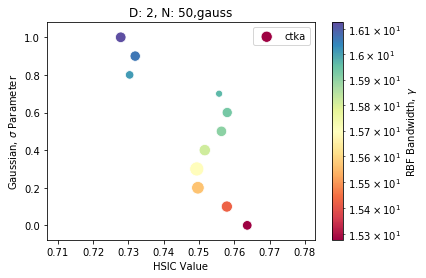

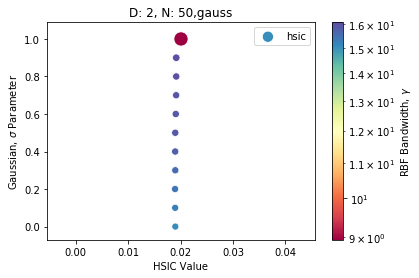

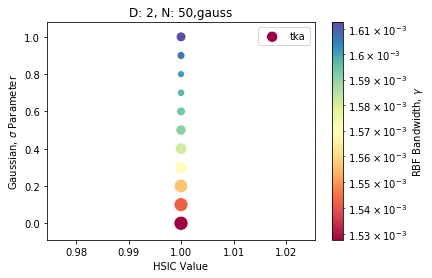

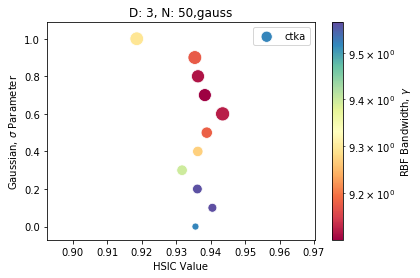

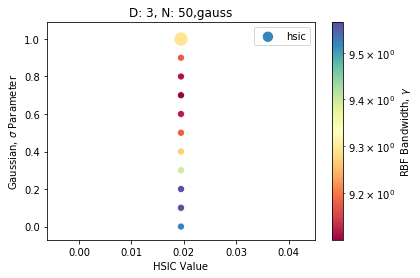

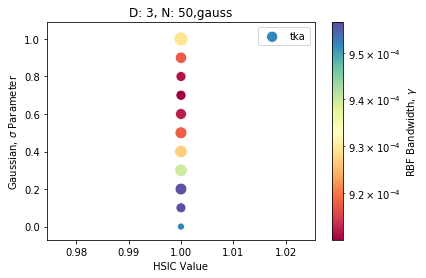

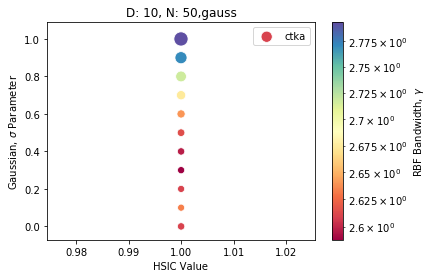

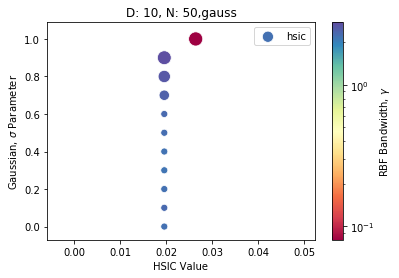

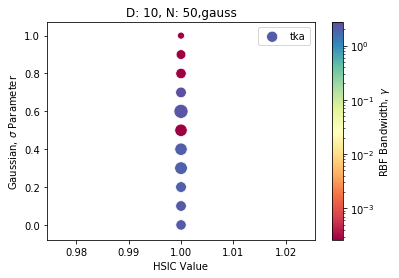

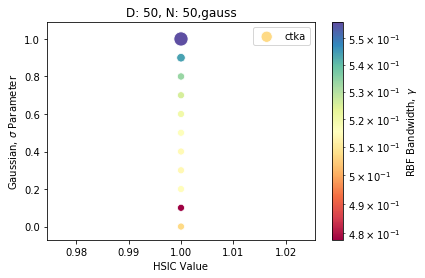

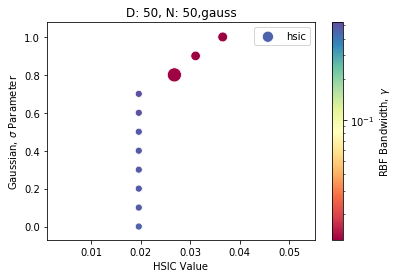

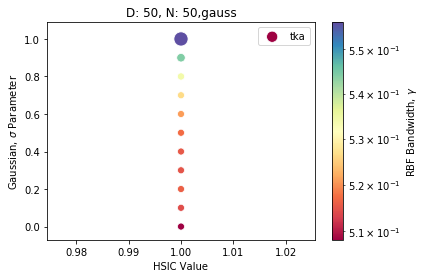

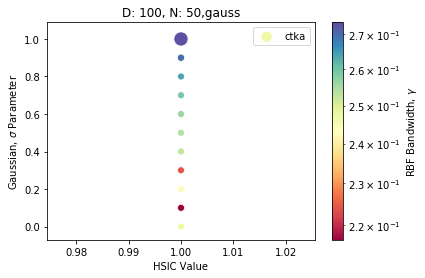

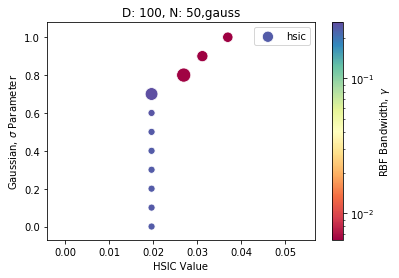

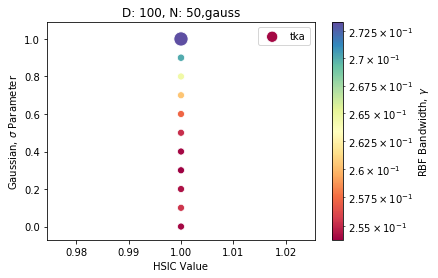

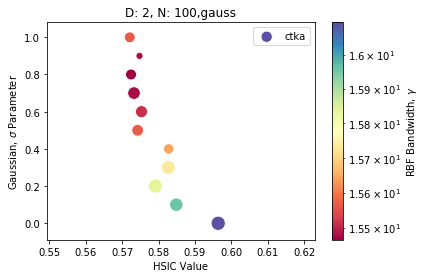

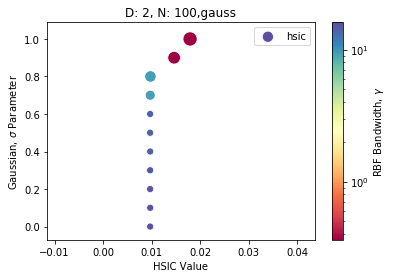

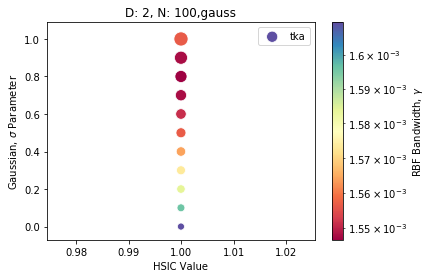

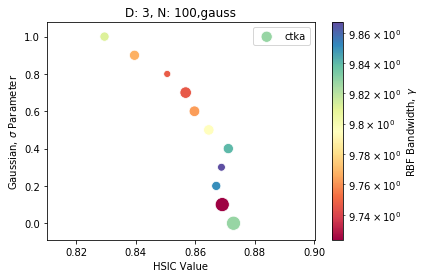

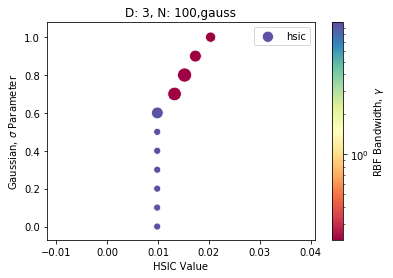

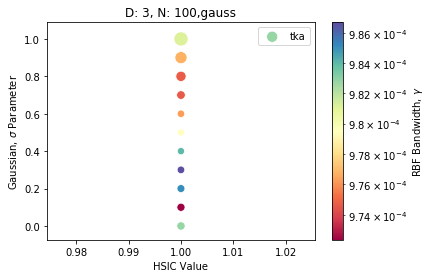

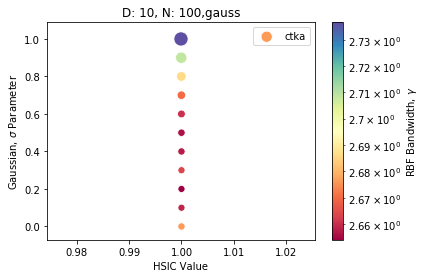

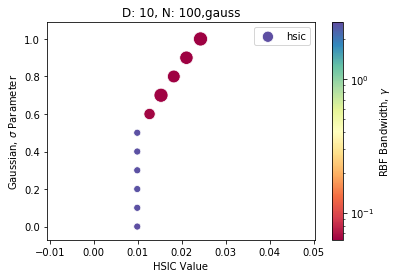

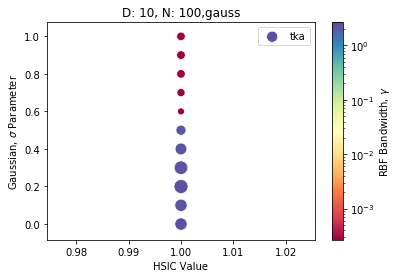

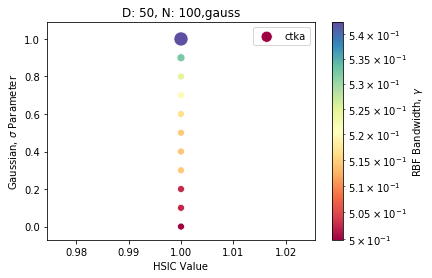

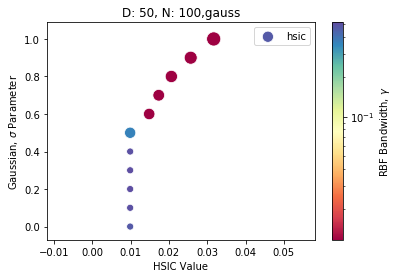

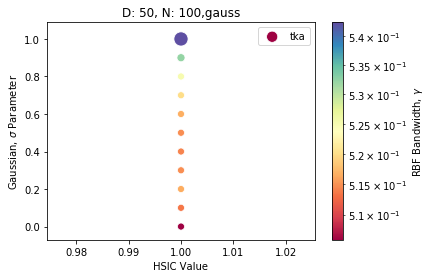

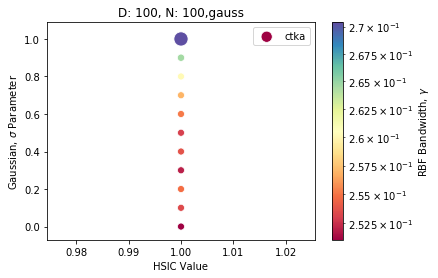

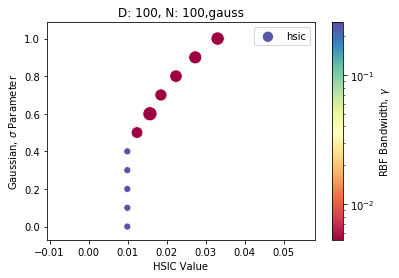

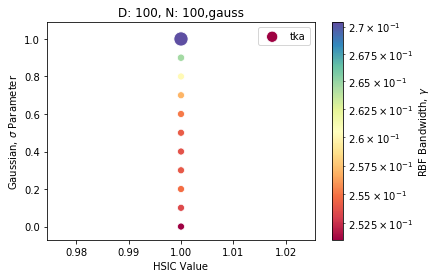

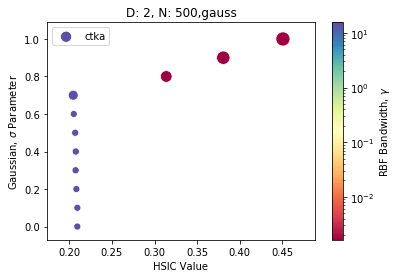

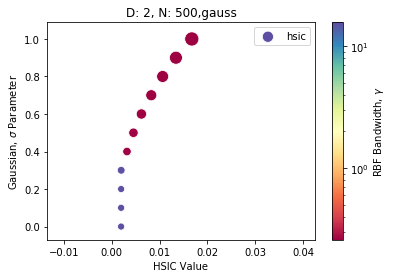

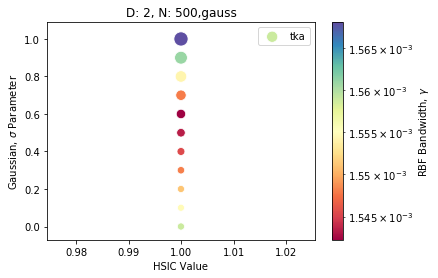

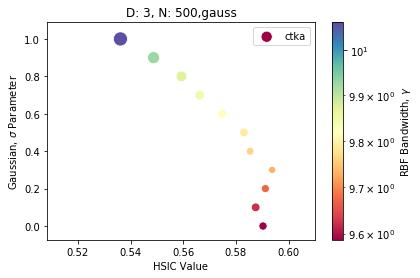

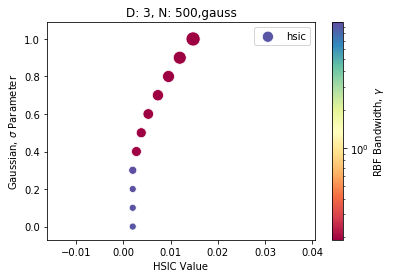

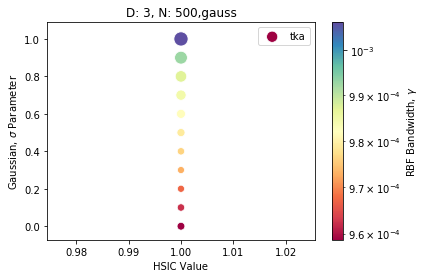

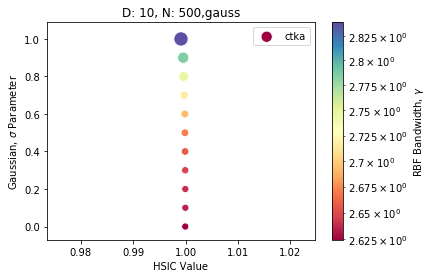

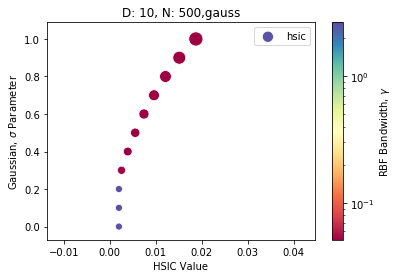

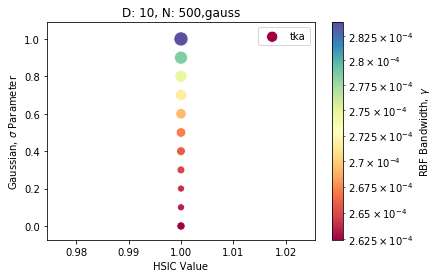

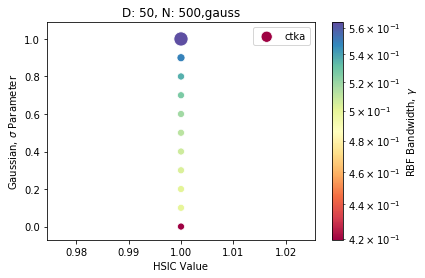

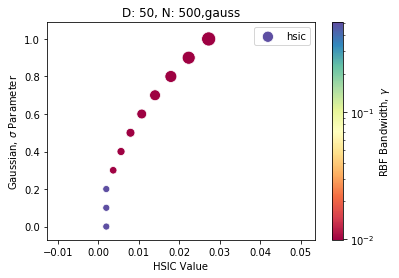

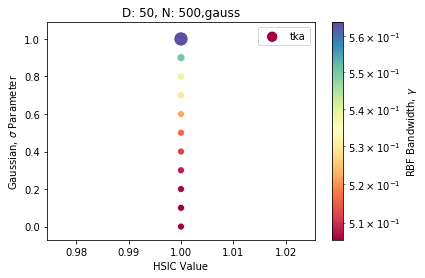

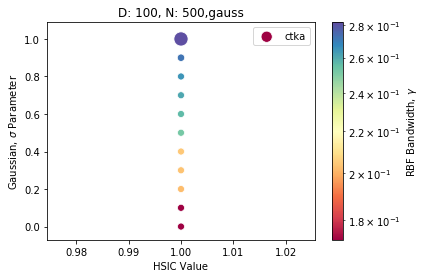

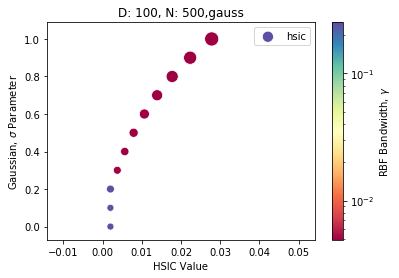

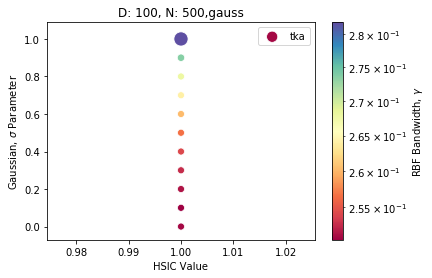

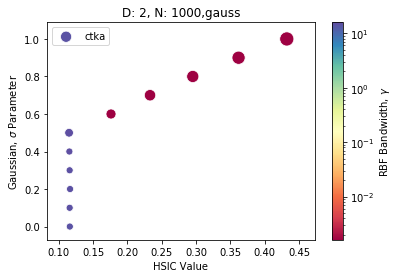

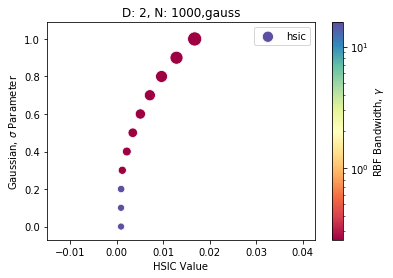

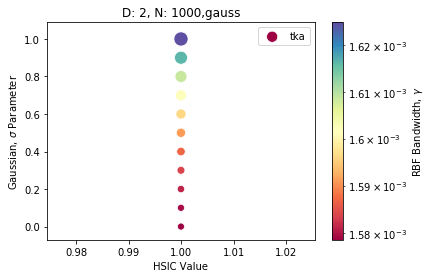

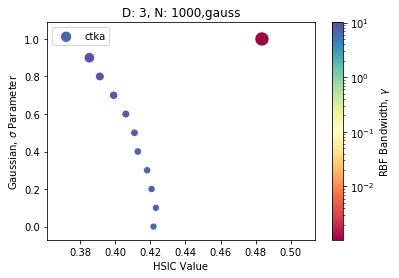

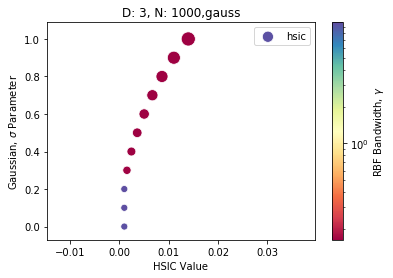

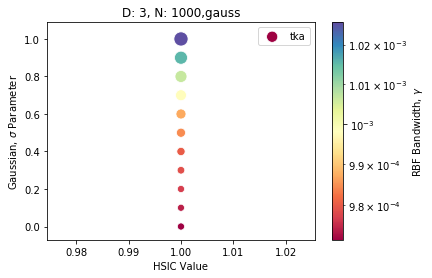

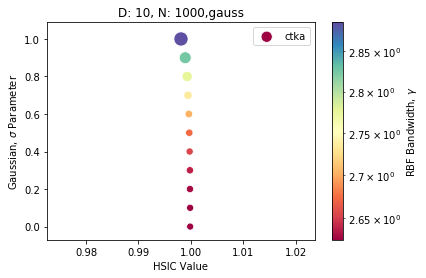

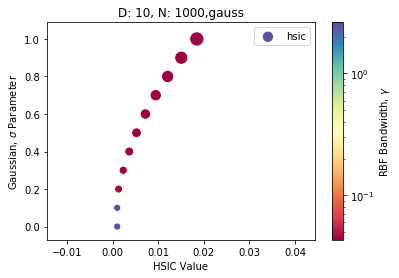

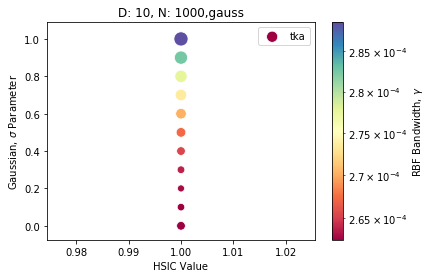

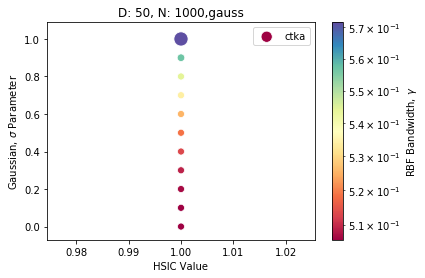

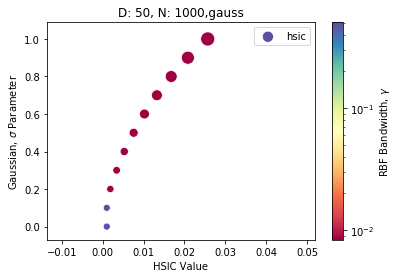

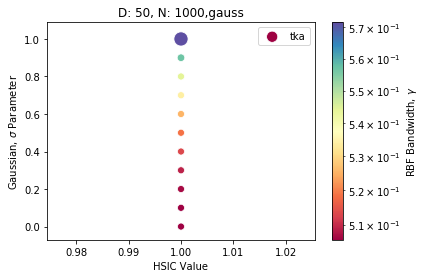

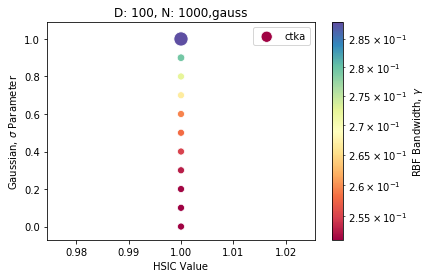

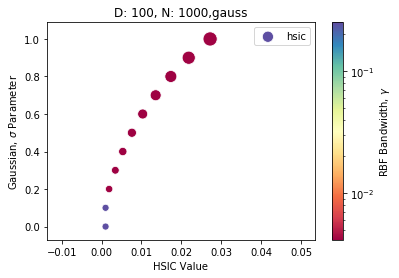

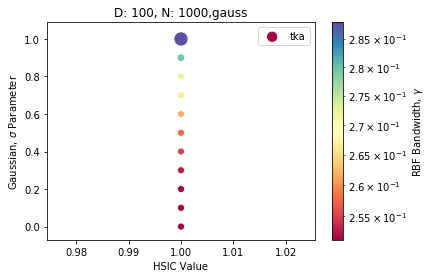

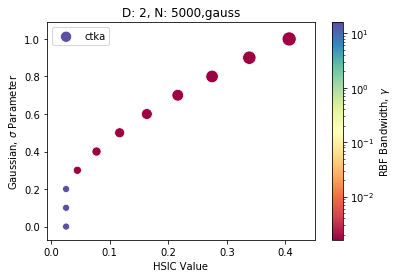

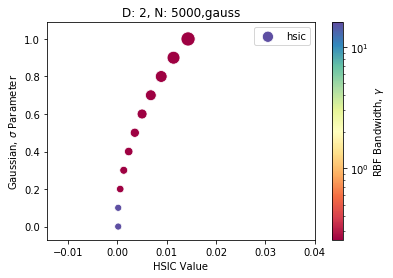

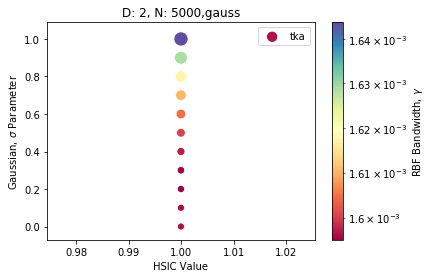

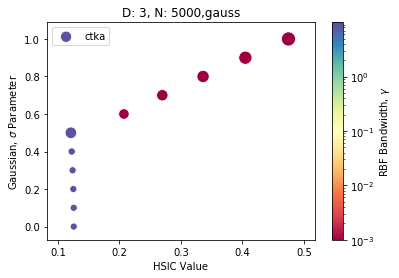

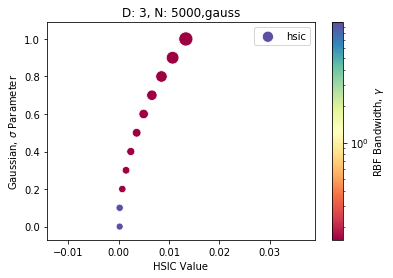

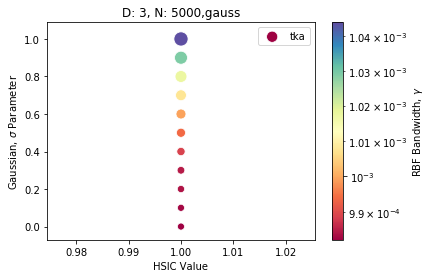

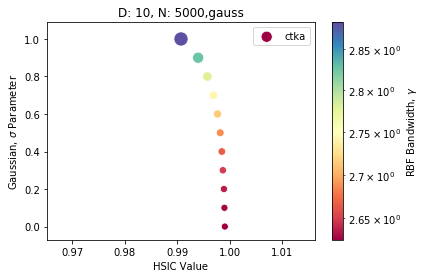

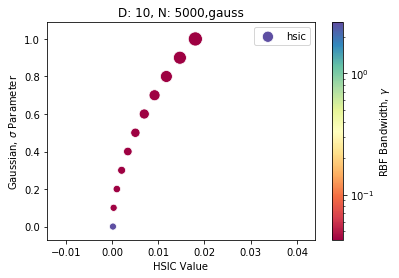

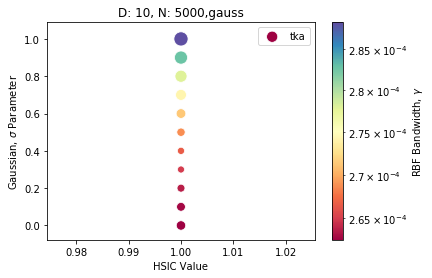

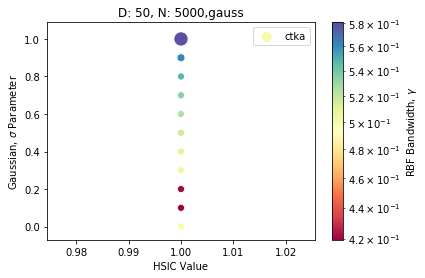

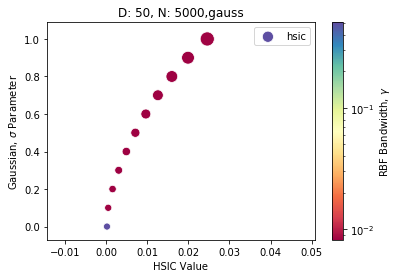

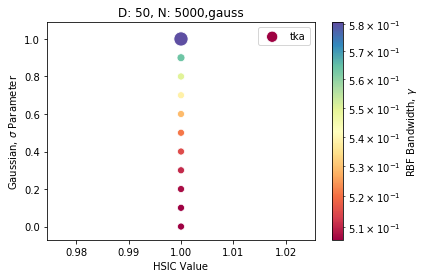

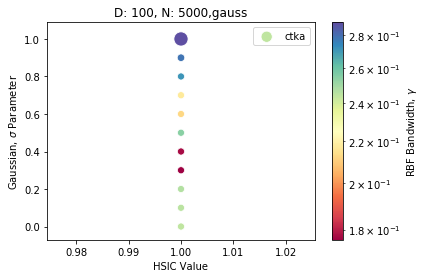

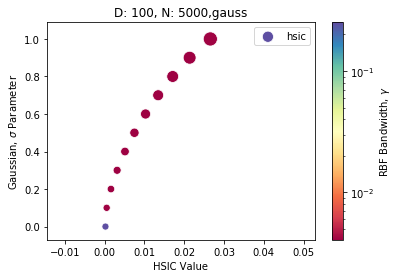

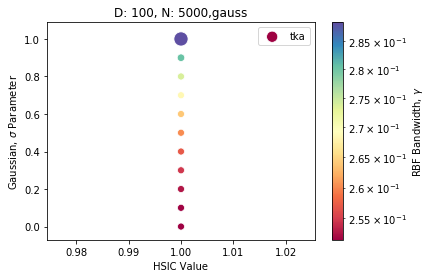

In [308]:
for igroup in subres:
    
    
    igroup, fixed_vars = plot_prepare(igroup[1])
    
    t = igroup

    plot_gauss(igroup, fixed_vars, save=False)

In [ ]:
for igroup in subres:
    
    
    igroup, fixed_vars = plot_prepare(igroup[1])
    
    t = igroup

    plot_tstudent(igroup, fixed_vars, save=False)


In [ ]:
plot_groups = ['dataset', 'n_samples', 'd_dimensions', 'dataset', ]

subres = results_tstudent.groupby(plot_groups)

In [297]:
np.linspace(1, 100, 5)

array([  1.  ,  25.75,  50.5 ,  75.25, 100.  ])

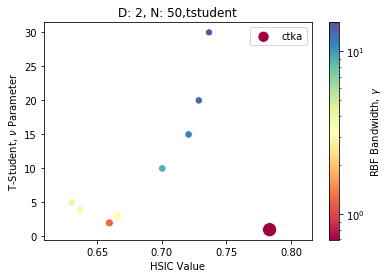

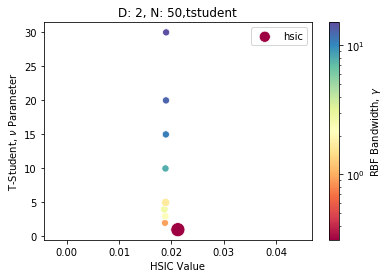

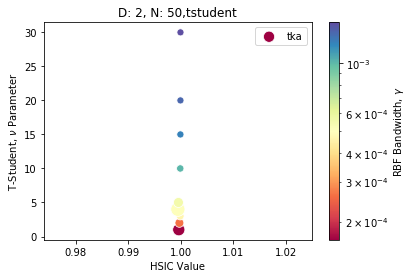

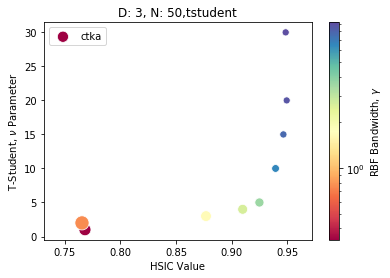

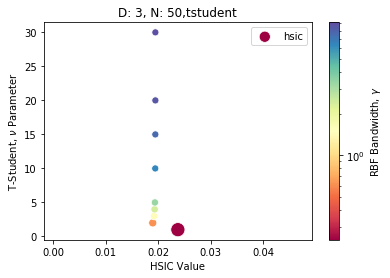

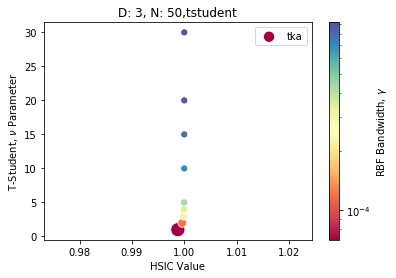

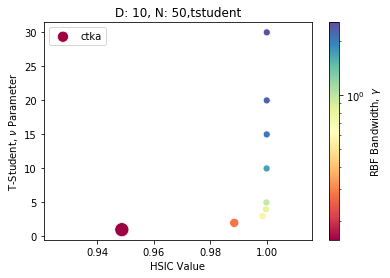

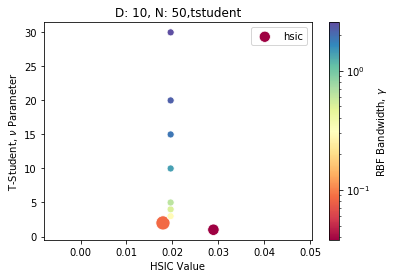

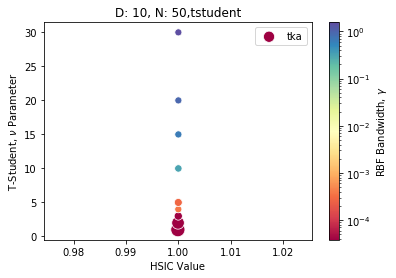

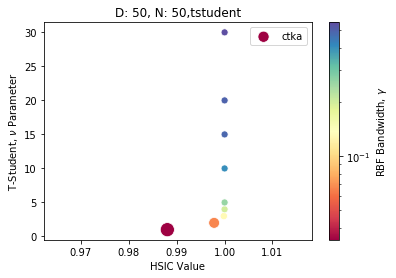

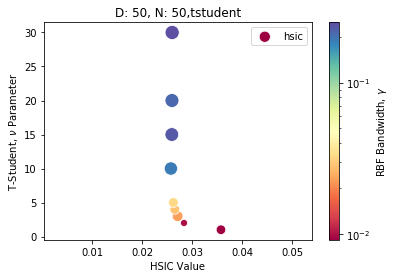

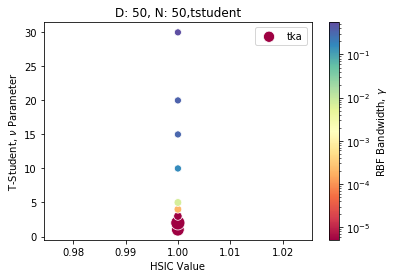

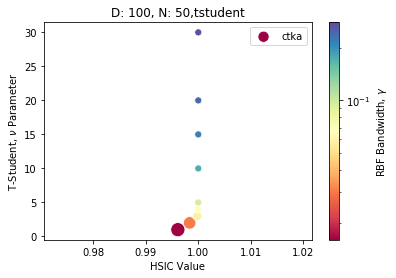

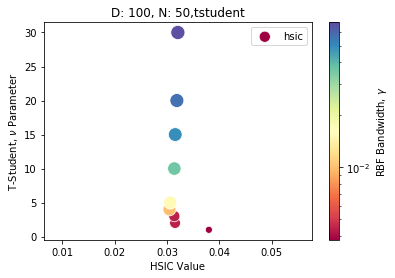

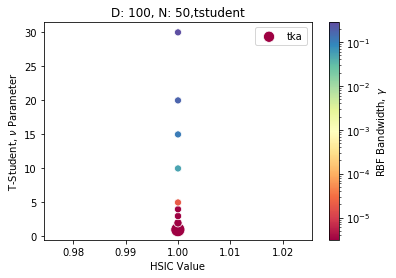

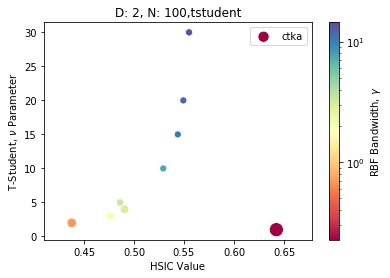

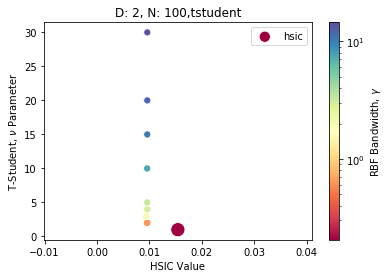

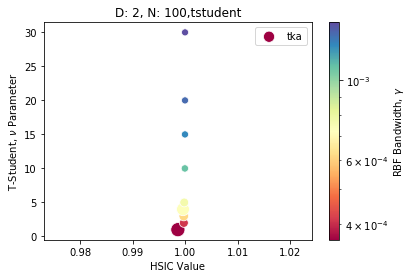

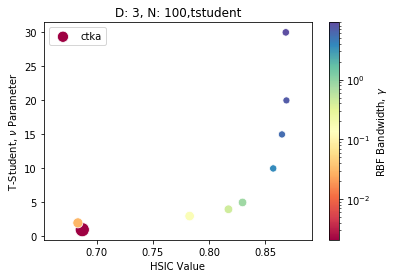

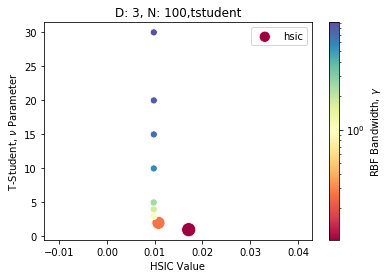

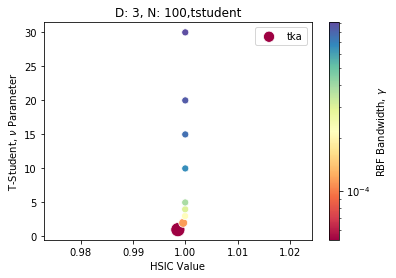

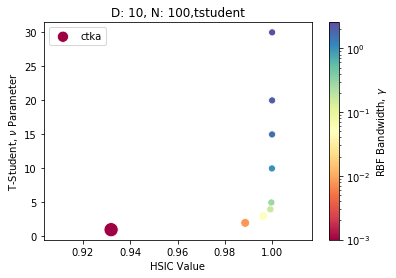

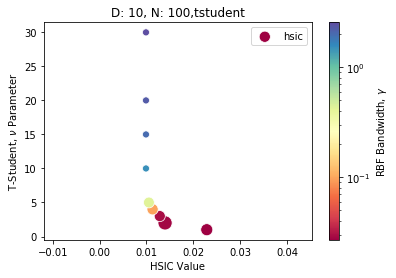

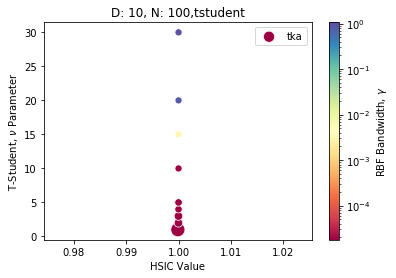

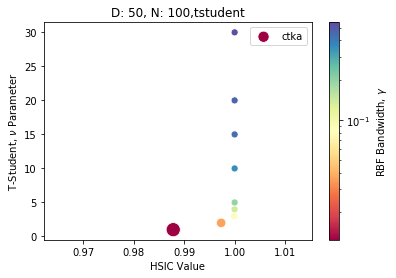

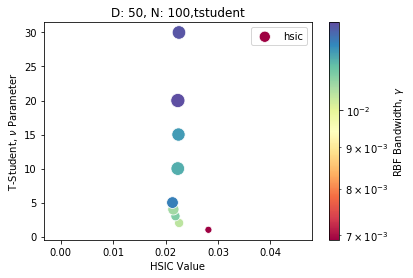

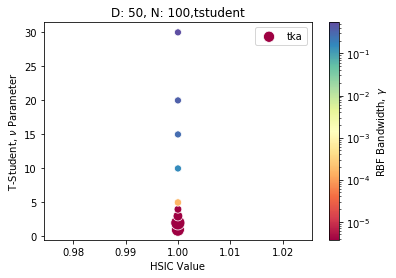

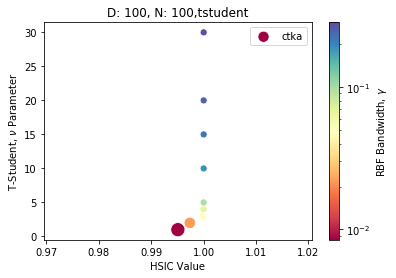

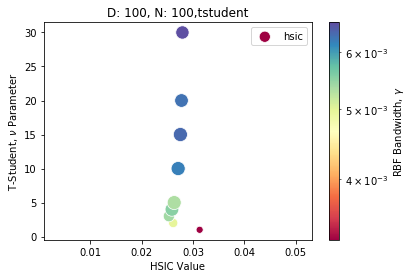

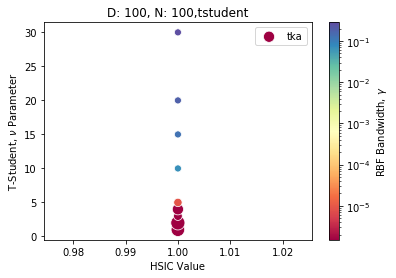

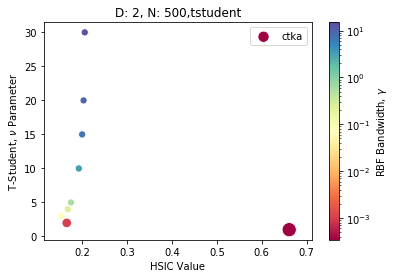

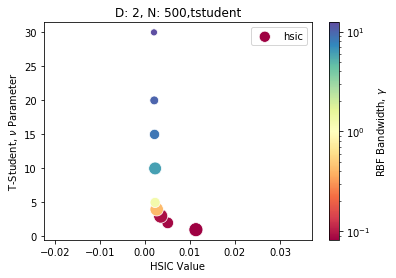

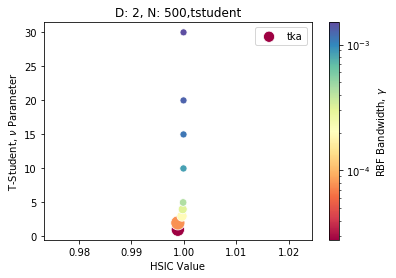

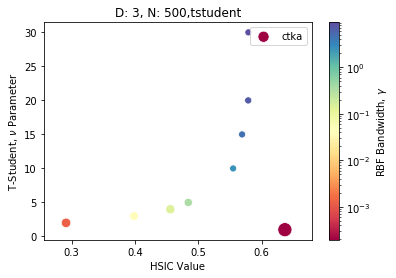

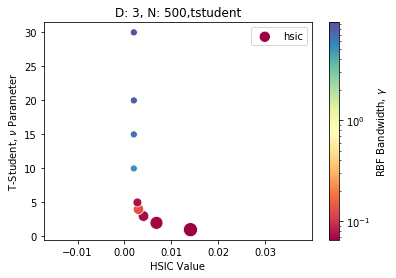

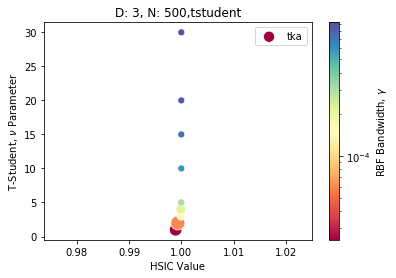

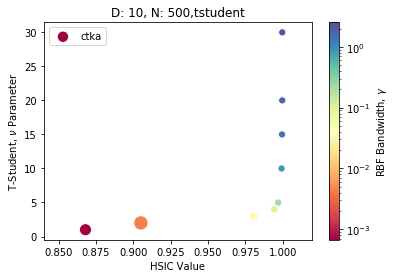

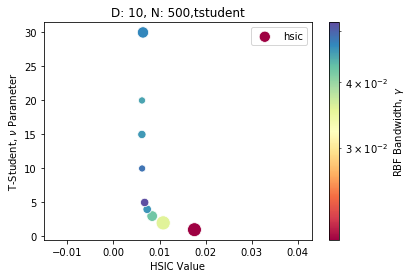

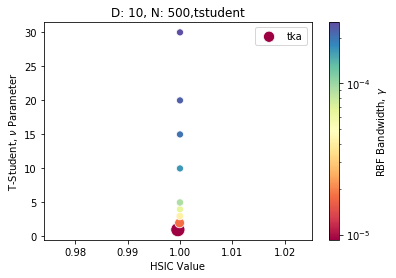

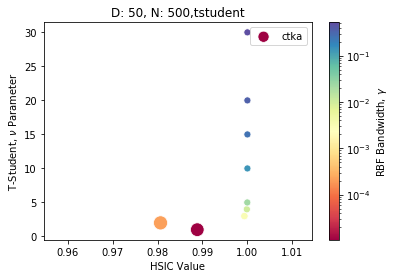

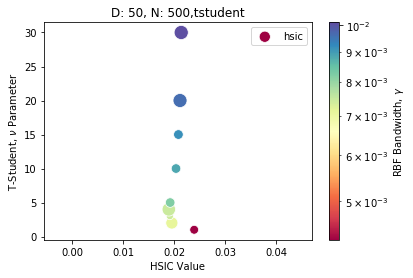

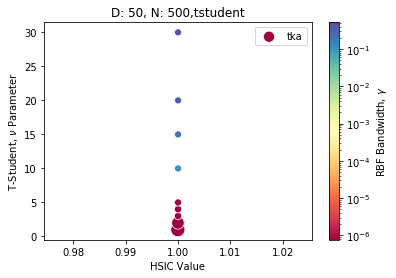

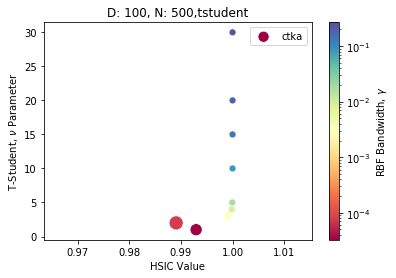

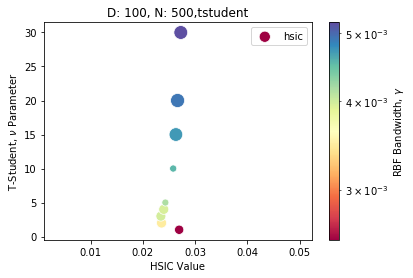

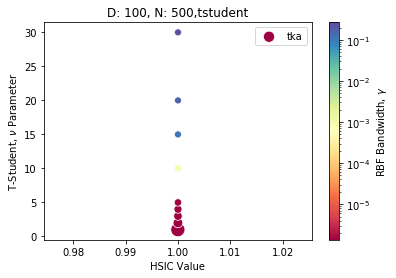

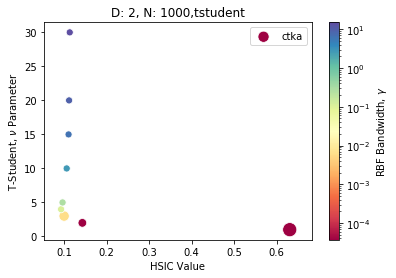

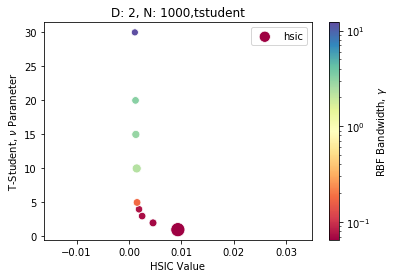

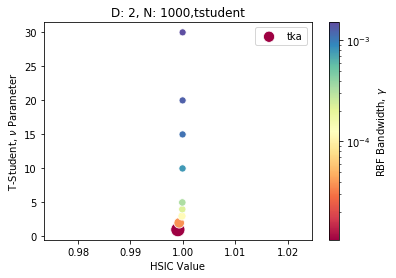

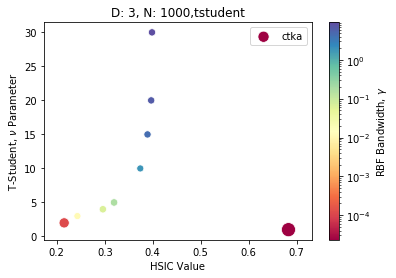

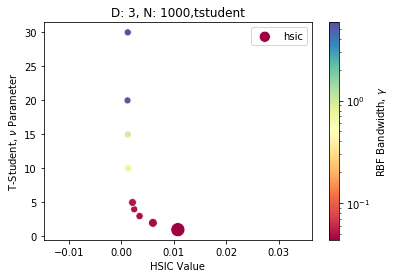

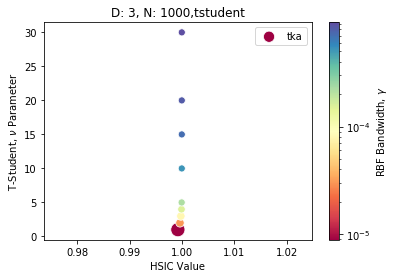

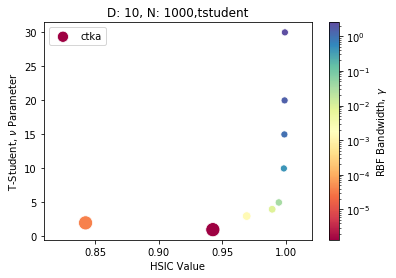

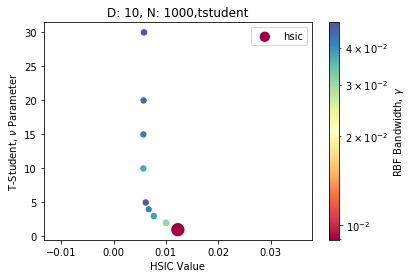

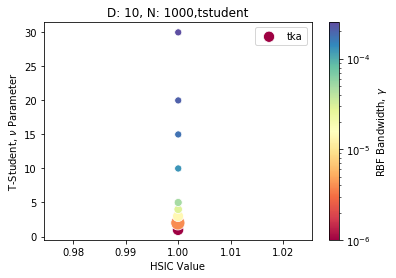

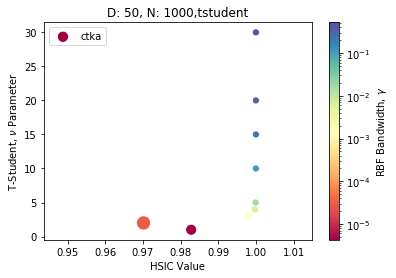

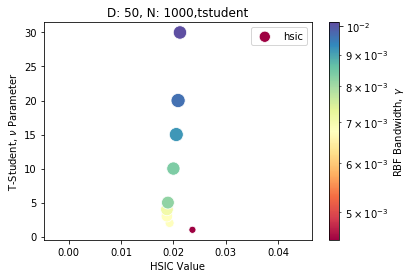

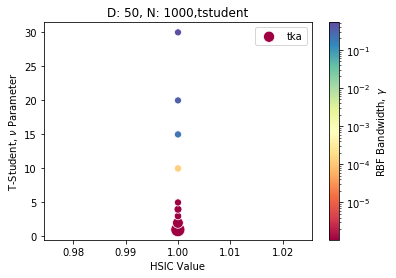

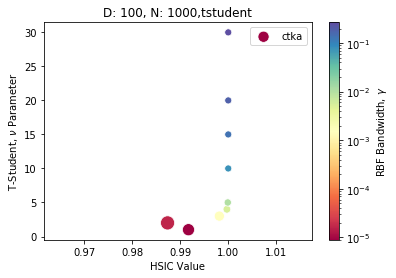

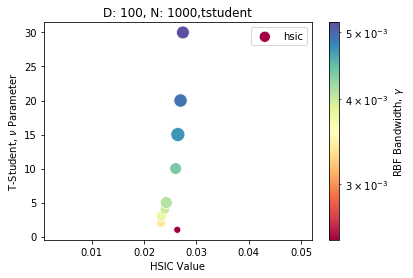

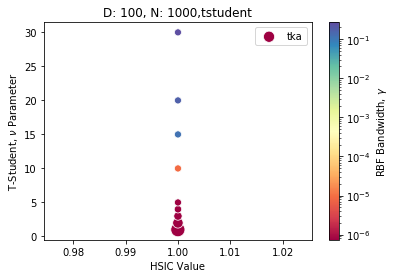

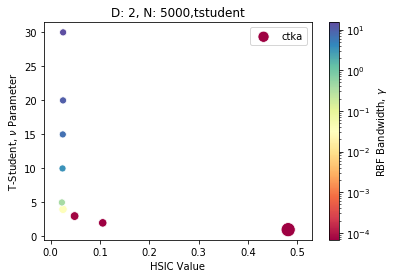

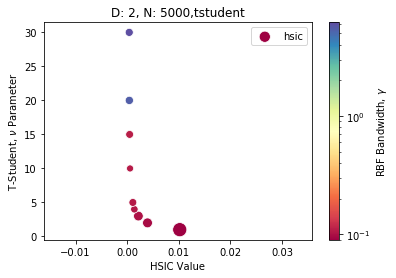

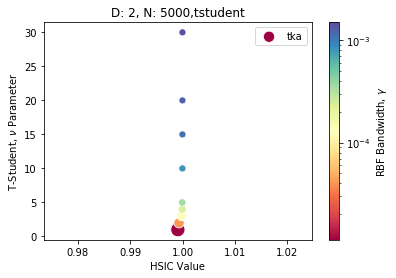

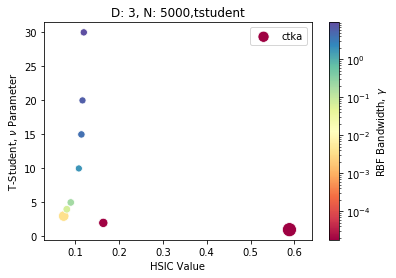

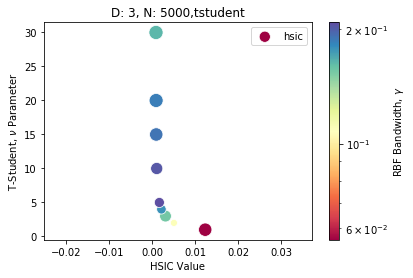

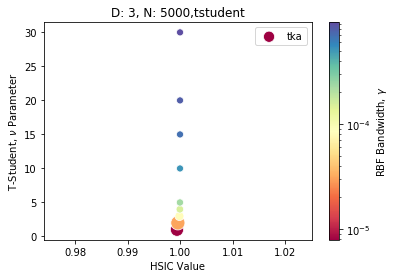

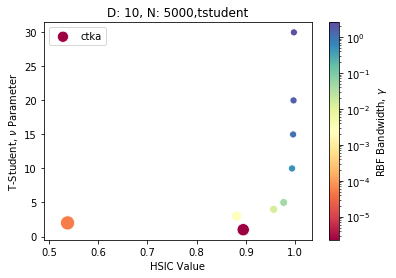

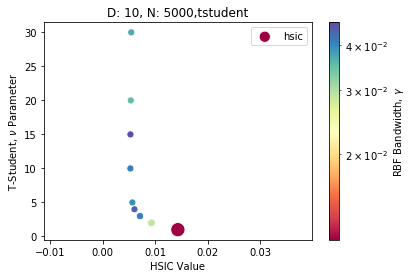

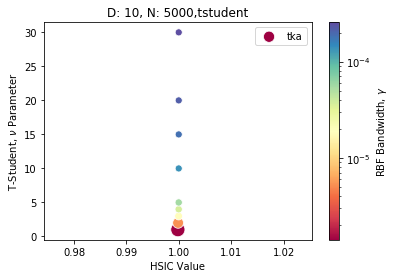

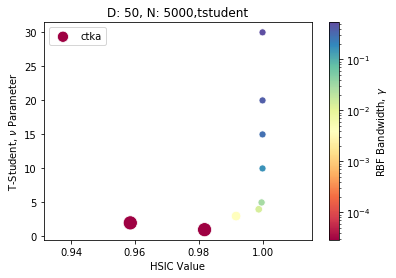

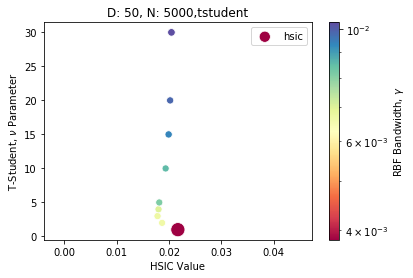

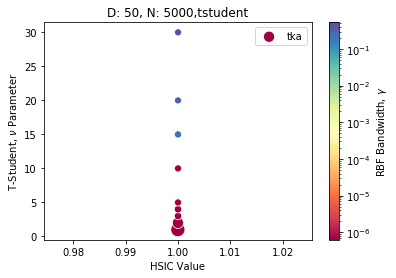

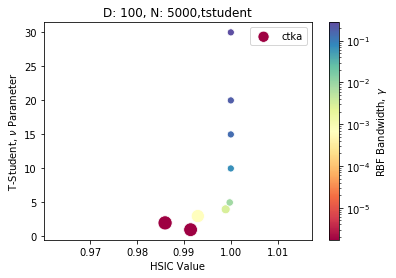

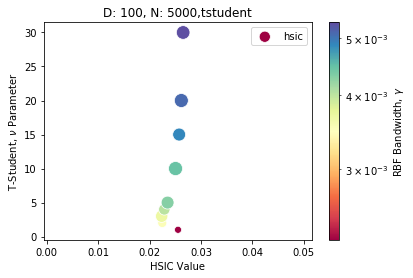

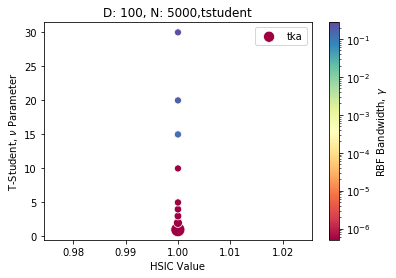

In [166]:
fixed_vars.keys()

dict_keys(['d_dimensions', 'n_samples', 'dataset', 'scorer'])

In [100]:
t.groupby(['dataset', 'd_dimensions', 'scorer', 'nu']).mean()

trial  n_samples  std      gamma  \
dataset  d_dimensions scorer nu                                       
tstudent 2            ctka   1.0       3         50  NaN   0.696469   
                             2.0       3         50  NaN   3.411414   
                             3.0       3         50  NaN   7.953236   
                             4.0       3         50  NaN   8.503696   
                             5.0       3         50  NaN   9.013576   
                             10.0      3         50  NaN  12.641237   
                             15.0      3         50  NaN  13.868945   
                             20.0      3         50  NaN  14.480582   
                             30.0      3         50  NaN  15.092759   
                      hsic   1.0       3         50  NaN   0.311456   
                             2.0       3         50  NaN   4.483172   
                             3.0       3         50  NaN   7.953236   
                             4.0       3         50  NaN   8.503696   
                             5.0       3         50  NaN   6.739547   
                             10.0      3         50  NaN  12.641237   
                             15.0      3         50  NaN  13.868945   
                             20.0      3         50  NaN  14.480582   
                             30.0      3         50  NaN  15.092759   
                      tka    1.0       3         50  NaN   0.000166   
                             2.0       3         50  NaN   0.000448   
                             3.0       3         50  NaN   0.000795   
                             4.0       3         50  NaN   0.000850   
                             5.0       3         50  NaN   0.000901   
                             10.0      3         50  NaN   0.001264   
                             15.0      3         50  NaN   0.001387   
                             20.0      3         50  NaN   0.001448   
                             30.0      3         50  NaN   0.001509   

                                   gamma_median  gamma_silv  gamma_scott  \
dataset  d_dimensions scorer nu                                            
tstudent 2            ctka   1.0       3.637672    0.521001     0.521001   
                             2.0       2.371588    0.521001     0.521001   
                             3.0       2.072371    0.521001     0.521001   
                             4.0       1.937548    0.521001     0.521001   
                             5.0       1.871554    0.521001     0.521001   
                             10.0      1.761699    0.521001     0.521001   
                             15.0      1.729998    0.521001     0.521001   
                             20.0      1.708761    0.521001     0.521001   
                             30.0      1.687802    0.521001     0.521001   
                      hsic   1.0       3.637672    0.521001     0.521001   
                             2.0       2.371588    0.521001     0.521001   
                             3.0       2.072371    0.521001     0.521001   
                             4.0       1.937548    0.521001     0.521001   
                             5.0       1.871554    0.521001     0.521001   
                             10.0      1.761699    0.521001     0.521001   
                             15.0      1.729998    0.521001     0.521001   
                             20.0      1.708761    0.521001     0.521001   
                             30.0      1.687802    0.521001     0.521001   
                      tka    1.0       3.637672    0.521001     0.521001   
                             2.0       2.371588    0.521001     0.521001   
                             3.0       2.072371    0.521001     0.521001   
                             4.0       1.937548    0.521001     0.521001   
                             5.0       1.871554    0.521001     0.521001   
                             10.0      1.761699    0.521001     0.521001   

In [101]:
t.groupby(['dataset', 'd_dimensions', 'scorer', 'nu']).std()

trial  n_samples  std     gamma  \
dataset  d_dimensions scorer nu                                         
tstudent 2            ctka   1.0   1.581139        0.0  NaN  0.961500   
                             2.0   1.581139        0.0  NaN  3.214027   
                             3.0   1.581139        0.0  NaN  1.950137   
                             4.0   1.581139        0.0  NaN  2.417514   
                             5.0   1.581139        0.0  NaN  2.490371   
                             10.0  1.581139        0.0  NaN  2.329043   
                             15.0  1.581139        0.0  NaN  2.218147   
                             20.0  1.581139        0.0  NaN  2.141577   
                             30.0  1.581139        0.0  NaN  2.040238   
                      hsic   1.0   1.581139        0.0  NaN  0.259527   
                             2.0   1.581139        0.0  NaN  1.872368   
                             3.0   1.581139        0.0  NaN  1.950137   
                             4.0   1.581139        0.0  NaN  2.417514   
                             5.0   1.581139        0.0  NaN  2.648875   
                             10.0  1.581139        0.0  NaN  2.329043   
                             15.0  1.581139        0.0  NaN  2.218147   
                             20.0  1.581139        0.0  NaN  2.141577   
                             30.0  1.581139        0.0  NaN  2.040238   
                      tka    1.0   1.581139        0.0  NaN  0.000181   
                             2.0   1.581139        0.0  NaN  0.000187   
                             3.0   1.581139        0.0  NaN  0.000195   
                             4.0   1.581139        0.0  NaN  0.000242   
                             5.0   1.581139        0.0  NaN  0.000249   
                             10.0  1.581139        0.0  NaN  0.000233   
                             15.0  1.581139        0.0  NaN  0.000222   
                             20.0  1.581139        0.0  NaN  0.000214   
                             30.0  1.581139        0.0  NaN  0.000204   

                                   gamma_median  gamma_silv  gamma_scott  \
dataset  d_dimensions scorer nu                                            
tstudent 2            ctka   1.0       0.782348         0.0          0.0   
                             2.0       0.304070         0.0          0.0   
                             3.0       0.211945         0.0          0.0   
                             4.0       0.172598         0.0          0.0   
                             5.0       0.178211         0.0          0.0   
                             10.0      0.139662         0.0          0.0   
                             15.0      0.119495         0.0          0.0   
                             20.0      0.111909         0.0          0.0   
                             30.0      0.106456         0.0          0.0   
                      hsic   1.0       0.782348         0.0          0.0   
                             2.0       0.304070         0.0          0.0   
                             3.0       0.211945         0.0          0.0   
                             4.0       0.172598         0.0          0.0   
                             5.0       0.178211         0.0          0.0   
                             10.0      0.139662         0.0          0.0   
                             15.0      0.119495         0.0          0.0   
                             20.0      0.111909         0.0          0.0   
                             30.0      0.106456         0.0          0.0   
                      tka    1.0       0.782348         0.0          0.0   
                             2.0       0.304070         0.0          0.0   
                             3.0       0.211945         0.0          0.0   
                             4.0       0.172598         0.0          0.0   
                             5.0       0.178211         0.0          0.0   
                    